<h1>Assignment 1:</h1>

The objective of this assignment is to assess the impact of algorithm bias on machine learning algorithms trained with imbalanced data. This submission will also propose and evaluate strategies for overcoming this bias. The dataset used (appendicitis.csv) is derived from the UCI dataset at [https://archive.ics.uci.edu/dataset/938/regensburg+pediatric+appendicitis](https://archive.ics.uci.edu/dataset/938/regensburg+pediatric+appendicitis)

In [493]:
import pandas as pd
import numpy as np
from imblearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier

<h2>Task 1:</h2>

Load the dataset using pandas.

In [494]:
raw = pd.read_csv("./appendicitis.csv")
raw.head()

,Unnamed: 0,Age,BMI,Sex,Height,Weight,Length_of_Stay,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Migratory_Pain,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Coughing_Pain,Nausea,Loss_of_Appetite,Body_Temperature,WBC_Count,Dysuria,Diagnosis
0,0,12.68,16.90,1,148.0,37.0,3.0,4.0,3.0,1,0,1,1,0,0,1,37.0,7.7,0,appendicitis
1,672,10.21,15.59,1,145.5,33.0,7.0,9.0,8.0,0,1,1,0,0,1,1,38.4,17.0,0,appendicitis
2,671,7.55,16.76,1,136.0,31.0,3.0,5.0,3.0,1,0,1,0,0,0,0,37.8,16.1,0,appendicitis
3,670,14.79,23.23,0,166.0,64.0,4.0,7.0,8.0,1,1,1,0,1,1,0,36.8,20.6,0,appendicitis
4,669,9.66,16.22,0,149.0,36.0,4.0,10.0,10.0,1,1,1,1,1,1,1,38.0,19.9,0,appendicitis


Pop the unnamed, presumably index column, shuffle the data as there are significant groupings of appendicitis and non-appendicitis diagnoses, 
then convert to numpy arrays

In [495]:
raw.pop(raw.columns[0])

raw = raw.sample(frac=1).reset_index(drop=True)

Yraw = raw.pop("Diagnosis").values
Xraw = raw.values
type(Xraw),type(Yraw)

(numpy.ndarray, numpy.ndarray)

We can then convert this data to ordinal using sklearns ordinal encoder and normalize inputs to be $0 \leq x_n \leq 1$:

In [496]:
Xraw_ord = OrdinalEncoder().fit_transform(Xraw)

scaler = MinMaxScaler().fit(Xraw_ord)
Xraw_ord = scaler.transform(Xraw_ord)

Xraw_ord

array([[0.72154472, 0.31567329, 1.        , ..., 0.52272727, 0.23267327,
        0.        ],
       [0.81097561, 0.66666667, 1.        , ..., 0.31818182, 0.21782178,
        1.        ],
       [0.31910569, 0.26710817, 0.        , ..., 0.04545455, 0.54455446,
        0.        ],
       ...,
       [0.99593496, 0.799117  , 0.        , ..., 0.18181818, 0.53960396,
        0.        ],
       [0.30487805, 0.09492274, 1.        , ..., 0.61363636, 0.48514851,
        0.        ],
       [0.09349593, 0.03532009, 0.        , ..., 0.29545455, 0.8960396 ,
        0.        ]])

<h4>We can now train and generate predictions with kNN and Decision tree models using cross validation</h4>

In [497]:
kNN = KNeighborsClassifier(n_neighbors=3, weights='distance') 
tree = DecisionTreeClassifier()

cv = StratifiedKFold(n_splits=10)

Y_pred_kNN = cross_val_predict(kNN, Xraw_ord, Yraw, cv=cv)
Y_pred_tree = cross_val_predict(tree, Xraw_ord, Yraw, cv=cv)

We can then produce a confusion matrix for each using cross validation:
I have normalised these on the true axis, such that all rows of the matrix sum to 1, this allows us to differentiate prediction accuracy of appendicits and no-appendicitis diagnoses

Text(0.5, 1.0, 'kNN Confusion Matrix')

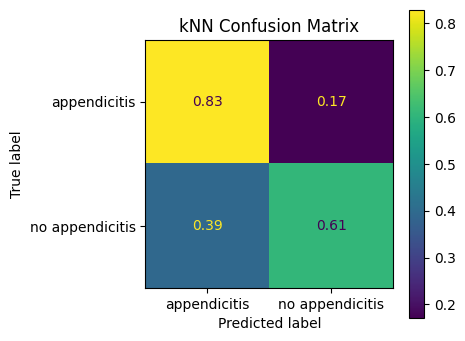

In [498]:
fig,axes = plt.subplots(figsize=(4, 4))
kNN_display = ConfusionMatrixDisplay.from_predictions(Yraw, Y_pred_kNN, ax=axes, normalize='true')
plt.title("kNN Confusion Matrix")

Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

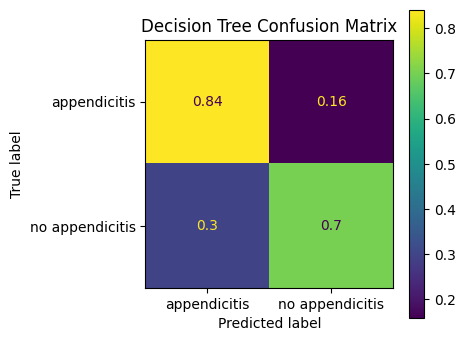

In [499]:
fig,axes = plt.subplots(figsize=(4, 4))
tree_display = ConfusionMatrixDisplay.from_predictions(Yraw, Y_pred_tree, ax=axes, normalize='true')
plt.title("Decision Tree Confusion Matrix")

We can see a clear difference here in the correct predictions, with the true negative and true positive numbers differing by usually 0.2-0.3 

We can calculate the recall(sensitivity), precision and f1-score of these using the classification report function in sklearn:

In [500]:
print("kNN classification report:\n", classification_report(Yraw, Y_pred_kNN))

kNN classification report:
                  precision    recall  f1-score   support

   appendicitis       0.77      0.83      0.80       390
no appendicitis       0.69      0.61      0.64       241

       accuracy                           0.74       631
      macro avg       0.73      0.72      0.72       631
   weighted avg       0.74      0.74      0.74       631



In [501]:
print("Decision Tree classification report:\n", classification_report(Yraw, Y_pred_tree))

Decision Tree classification report:
                  precision    recall  f1-score   support

   appendicitis       0.82      0.84      0.83       390
no appendicitis       0.73      0.70      0.72       241

       accuracy                           0.79       631
      macro avg       0.78      0.77      0.77       631
   weighted avg       0.79      0.79      0.79       631



From the Precision and recall scores of each algorithm, we can see that both algorithms are relatively effective at classifying appendicitis results, on the other hand, they both are significantly worse at classifying no-appendicitis patients and tend to misdiagnose it (recall=0.61/0.70) as a False Positive.

If we then look at the distribution of appendicitis vs no-appendicitis diagnoses in the raw dataset, we see that there are significantly more appendicitis diagnoses than no-appendicitis

Text(0.5, 1.0, 'Proportion of appendicitis vs no appendicitis diagnoses in the entire source dataset')

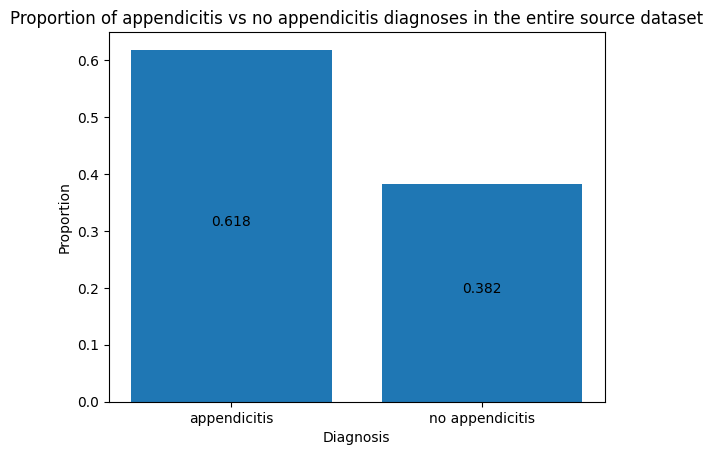

In [502]:
unique, counts = np.unique(Yraw, return_counts=True)
plt.bar(unique, counts/len(Yraw))
plt.xlabel("Diagnosis")
plt.ylabel("Proportion")
plt.text(unique[0], (counts[0]/len(Yraw))/2, round(counts[0]/len(Yraw), 3), ha = 'center')
plt.text(unique[1], (counts[1]/len(Yraw))/2, round(counts[1]/len(Yraw), 3), ha = 'center')
plt.title("Proportion of appendicitis vs no appendicitis diagnoses in the entire source dataset")

We can see that these models both show a bias in both precision and recall toward appendicitis diagnoses, which aligns with the fact that there are more appendicits diagnoses in the source dataset. The confusion matrices both support this theory aswell, as we can see substantially higher accuracy in the appendicitis diagnoses than the no-appendicitis diagnoses.

Interestingly, the Decision tree model seems to perform notably better than kNN, and this will be investigated further once measures are taken to reduce algorithm bias.

<h2>Task 2:</h2>

The purpose of this task is to investigate and implement methods of reducing the impact of bias with the Decision Tree classifier trained on this imbalanced dataset.

I tried many methods to reduce the bias of the Decision tree classifier including class weights, PCA, Boosting, and more. The one's I tried which showed some promising results are as follows:

Firstly I tried tuning the hyperparameters of the Decision Tree classifier to reduce overfitting, and set the max_depth to 3, min_samples_split to 5 and min_samples_leaf to 3, I then combined this with ADASYN (Adaptive Synthetic, [Haibo He, et al.](https://www.researchgate.net/publication/224330873_ADASYN_Adaptive_Synthetic_Sampling_Approach_for_Imbalanced_Learning)) which synthesises new samples of the minority class in order to make the dataset more balanced. I found that adjusting the hyperparamets improved the model a lot, by approximately 0.05 in f1 score on both classes, while ADASYN made a slightly smaller, although still measurable improvement.

Decision Tree classification report (ADASYN):
                  precision    recall  f1-score   support

   appendicitis       0.84      0.94      0.88       390
no appendicitis       0.87      0.70      0.78       241

       accuracy                           0.85       631
      macro avg       0.85      0.82      0.83       631
   weighted avg       0.85      0.85      0.84       631



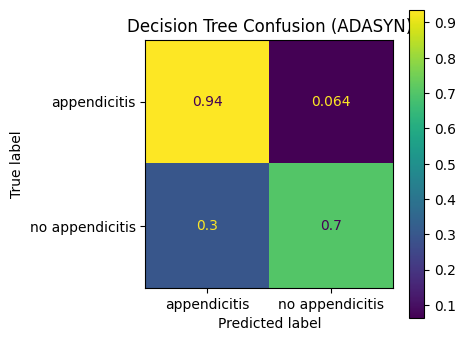

In [503]:
pipeline = Pipeline([
    ('adasyn', ADASYN()),
    ('classifier', DecisionTreeClassifier(max_depth=3, min_samples_split=5, min_samples_leaf=3))
])

Y_pred_tree = cross_val_predict(pipeline, Xraw_ord, Yraw, cv=cv)

fig,axes = plt.subplots(figsize=(4, 4))
tree_display = ConfusionMatrixDisplay.from_predictions(Yraw, Y_pred_tree, ax=axes, normalize='true')
plt.title("Decision Tree Confusion (ADASYN)")

print("Decision Tree classification report (ADASYN):\n", classification_report(Yraw, Y_pred_tree))

The notable tradeoff here however, it seems that the no-appendicitis diagnosis accuracy is approximately the same as before, these techniques have improved the appendicitis recall substantially, although the no-appendicits results are still about the same.

We can attempt to improve this using ensemble methods, notably a Random Forest classifier which works by creating a multitude of decision trees, using these, they can take the modal output of those trees for any given input sample, as the output of the classifier. This technique also aims to reduce overfitting of trees. I will implement this using imbalanced learn's BalancedRandomForestClassifier ([Chao Chen, et al.](https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf)), which is a slight modification of this algorithm in which each tree will be provided a balanced bootstrap sample.

Decision Tree classification report (Forest):
                  precision    recall  f1-score   support

   appendicitis       0.87      0.81      0.84       390
no appendicitis       0.73      0.80      0.76       241

       accuracy                           0.81       631
      macro avg       0.80      0.81      0.80       631
   weighted avg       0.82      0.81      0.81       631



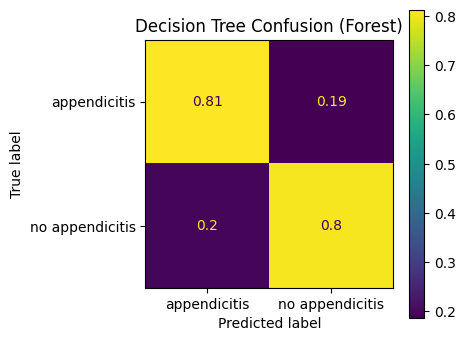

In [504]:
pipeline = Pipeline([
    ('adasyn', ADASYN()),
    ('classifier', BalancedRandomForestClassifier(n_estimators=100, max_depth=6, random_state=42,
                                                sampling_strategy='all', bootstrap=False, replacement=True,
                                                min_samples_split=5, min_samples_leaf=3))
])

Y_pred_tree = cross_val_predict(pipeline, Xraw_ord, Yraw, cv=cv)

fig,axes = plt.subplots(figsize=(4, 4))
tree_display = ConfusionMatrixDisplay.from_predictions(Yraw, Y_pred_tree, ax=axes, normalize='true')
plt.title("Decision Tree Confusion (Forest)")

print("Decision Tree classification report (Forest):\n", classification_report(Yraw, Y_pred_tree))

As shown above, the no-appendicitis recall is highest here out of any other model tested at 0.80. This figure is the best measure of bias available here as no-appendicits is the minority class. This essentially shows that the bias has been significantly reduced by the techniques mentioned above. The use of a Random Forest classifier has somewhat restructured the output. Where ADASYN and hyperparameter tuning got a high accuracy, with a large bias still present, Random Forest (although still using both of those techniques), balances the classifier such that the accuracy is slightly lower, but the bias toward the majority class is massively reduced.

<h2>Task 3</h2>

For this task we have the same objective of Task 2, reducing bias due to the imbalanced dataset, only this time we are going to focus our methods on the kNN model. Unfortunately, some of the techniques used to improve the decision tree classifier will not work here, namely Random Forest and Boosting, this is because these techniques rely on class weights and/or sample weights, which the scikit-learn kNN implementation does not support, I could work around this by adjusting the formula in the sklearn library or re-implementing it, but I think that is beyond the scope of this assignment and simply unnecessary, because there are other techniques we can use in their place.

We can begin similarly to Task 2, with hyperparameter tuning and datset resampling using ADASYN and the Pipeline feature. Although the n_neighbors value of 3 was optimal for the model above, using ADASYN forces us to tune this to reach higher performance.

kNN classification report:
                  precision    recall  f1-score   support

   appendicitis       0.79      0.69      0.74       390
no appendicitis       0.59      0.71      0.64       241

       accuracy                           0.70       631
      macro avg       0.69      0.70      0.69       631
   weighted avg       0.72      0.70      0.70       631



Text(0.5, 1.0, 'kNN Confusion Matrix')

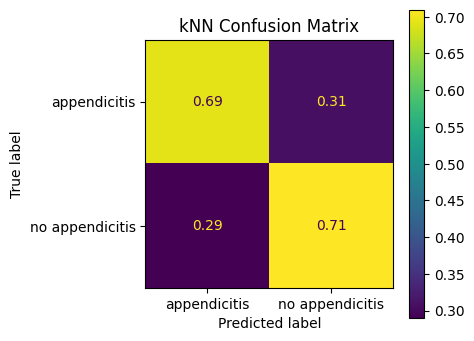

In [505]:
pipeline = Pipeline([
    ('adasyn', ADASYN()),
    ('classifier', KNeighborsClassifier(n_neighbors=6, weights='distance') )
])

Y_pred_kNN = cross_val_predict(pipeline, Xraw_ord, Yraw, cv=cv)

print("kNN classification report:\n", classification_report(Yraw, Y_pred_kNN))
fig,axes = plt.subplots(figsize=(4, 4))
kNN_display = ConfusionMatrixDisplay.from_predictions(Yraw, Y_pred_kNN, ax=axes, normalize='true')
plt.title("kNN Confusion Matrix")

We can see above that this does work for reducing bias (no-appendicitis recall of 0.71 vs 0.61 in base kNN), it comes at the cost of some accuracy. In an effort to reduce this loss of accuracy we can try the BalancedBaggingClassifier in imblearn, this basically fits many individual kNN classifiers each on a subset of the main dataset and then aggregates their predictions. Initially when I tried this, it performed notably worse than base kNN, but with some hyperparameter tuning, we can see a measurable reduction in bias and increase in accuracy.

kNN classification report:
                  precision    recall  f1-score   support

   appendicitis       0.84      0.73      0.78       390
no appendicitis       0.64      0.77      0.70       241

       accuracy                           0.74       631
      macro avg       0.74      0.75      0.74       631
   weighted avg       0.76      0.74      0.75       631



Text(0.5, 1.0, 'kNN Confusion Matrix')

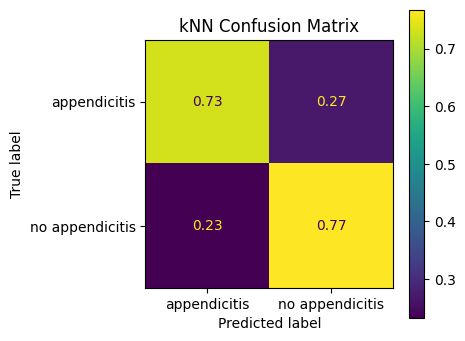

In [506]:
pipeline = Pipeline([
    ('adasyn', ADASYN()),
    ('classifier', BalancedBaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=6), n_estimators=60, max_samples=50, max_features=10))
])

Y_pred_kNN = cross_val_predict(pipeline, Xraw_ord, Yraw, cv=cv)

print("kNN classification report:\n", classification_report(Yraw, Y_pred_kNN))
fig,axes = plt.subplots(figsize=(4, 4))
kNN_display = ConfusionMatrixDisplay.from_predictions(Yraw, Y_pred_kNN, ax=axes, normalize='true')
plt.title("kNN Confusion Matrix")

<h2>Conclusions and Discussion:</h2>

In summary, we have shown that when trained on an imbalanced dataset, kNN and decision tree models are both biased toward the majority class. We have shown that it is possible to alleviate this bias by use of a number of techniques (oversampling, ensemble, hyperparameter tuning, etc).

As for the results, The final decision tree model significantly outperformed the non-optimised one, and was the overall best performer here with an accuracy of 0.81 and f1-scores of 0.84 and 0.76

The final kNN model, although performing substantially worse than the final decision tree, still significantly outperformed the base kNN classifier (in terms of bias) with an accuracy of 0.74 and f1-scores of 0.78 and 0.70

As shown by the f1-scores there, both models were able to reduce or even remove the bias, and in the case of the kNN model, even swung the other way and became very slightly biased toward the minority class. We can also see that this does sometimes come with a tradeoff, where majority class accuracy is lost at the cost of bias reduction. In an ideal world, if a model like this were to be deployed, ways to further improve its accuracy and resistance to bias could include:
<ul>
<li>Using a larger dataset, which would contain more minority class samples, allowing for better use of oversampling techniques.</li>
<li>Using a less imbalanced source dataset or performing pre-processing to reduce the imbalance in the dataset.</li>
<li>Using more refined techniques and models which are more resilient against dataset imbalance e.g. combining kNN with logisitic regression, decision trees etc.</li>
<li>Tuning the model for the situation, i.e. if FP results are not a big issue, the decision tree (ADASYN) model (3rd last) would be ideal, as it had the highest TP rate out of every model tested.</li>
<li>Using post-processing techniques such as threshold tuning to optimize the models further.</li>
<li>Using dimensionality reduction techniques on the source dataset to reduce overfitting.</li>
</ul>